# Weekly Momentum

## This code develops a momentum strategy with weekly rebalancing

Data sources: crsp, yahoo finance
# Weekly Momentum

## Load Packages

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import datetime
import time
import matplotlib.pyplot as plt
import wrds
from pandas.tseries.offsets import *

# Settings: shares code, exchange codes to use, sample period, folder for pictures/temporary data/outout
use_NYSE_brkpts = False

# Load and Save Data in .pkl format

In [2]:
# WRDS login information
data_folder = '../data/'
id_wrds = 'abhi1997'

# Share codes and exchage code that we'll use
min_shrcd = 10
max_shrcd = 12
possible_exchcd = (1, 2, 3)

# Time period
min_year = 2011
max_year = 2023

In [3]:
# Load Company names: 2022-2023 data from monthly data
conn = wrds.Connection(wrds_username=id_wrds)
names_raw = conn.raw_sql("""
                      select a.date, a.permno, b.ticker, b.comnam
                      from crspq.msf as a
                      left join crspq.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where b.shrcd between """ + str(min_shrcd) + """ and  """ + str(max_shrcd) + """
                      and a.date between '01/01/2022' and '12/31/2023'
                      and b.exchcd in """ + str(possible_exchcd) + """
                      """)
conn.close()
names_raw.to_pickle(data_folder + 'names_raw.pkl')
names_raw

Loading library list...
Done


,date,permno,ticker,comnam
0,2022-01-31,10028.0,ELA,ENVELA CORP
1,2022-02-28,10028.0,ELA,ENVELA CORP
2,2022-03-31,10028.0,ELA,ENVELA CORP
3,2022-04-29,10028.0,ELA,ENVELA CORP
4,2022-05-31,10028.0,ELA,ENVELA CORP
...,...,...,...,...
65314,2022-08-31,93266.0,QNST,QUINSTREET INC
65315,2022-09-30,93266.0,QNST,QUINSTREET INC
65316,2022-10-31,93266.0,QNST,QUINSTREET INC
65317,2022-11-30,93266.0,QNST,QUINSTREET INC


In [4]:
# Load CRSP returns (daily)
conn = wrds.Connection(wrds_username=id_wrds)
dcrsp_raw = conn.raw_sql("""
                      select a.permno, a.date, a.ret, b.ticker, a.shrout, a.prc
                      from crspq.dsf as a
                      left join crspq.dsenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where b.shrcd between """ + str(min_shrcd) + """ and  """ + str(max_shrcd) + """
                      and a.date between '01/01/""" +str(min_year)+ """' and '12/31/""" +str(max_year)+ """'
                      and b.exchcd in """ + str(possible_exchcd) + """
                      """)
conn.close()
dcrsp_raw.to_pickle(data_folder + 'dcrsp_raw.pkl')  # This is a large file (>500 MB), 
                                                    # If you don't have space use min_year = 2016
dcrsp_raw

Loading library list...
Done


,permno,date,ret,ticker,shrout,prc
0,85395.0,2011-01-03,-0.003868,PVSW,16044.0,5.150000
1,85397.0,2011-01-03,0.011478,RDCM,6145.0,11.280000
2,85401.0,2011-01-03,-0.031429,SIGA,49019.0,13.560000
3,85402.0,2011-01-03,0.002386,STRZ,3213.0,0.630300
4,85406.0,2011-01-03,0.014563,VCBI,28963.0,6.270000
...,...,...,...,...,...,...
148005,82179.0,2022-12-30,-0.010762,IART,83518.0,56.070000
148006,82212.0,2022-12-30,-0.008499,KFRC,20754.0,54.830002
148007,82215.0,2022-12-30,-0.032558,ENVB,2078.0,2.080000
148008,82234.0,2022-12-30,0.007692,FGH,19470.0,2.620000


In [5]:
# Load CRSP Deslisting returns (daily)
conn = wrds.Connection(wrds_username=id_wrds)
dlret_raw = conn.raw_sql("""
                      select a.permno, a.dlstdt, a.dlret, b.ticker
                      from crspq.dsedelist as a
                      left join crspq.dsenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.dlstdt
                      and a.dlstdt<=b.nameendt
                      where b.shrcd between """ + str(min_shrcd) + """ and  """ + str(max_shrcd) + """
                      and a.dlstdt between '01/01/""" +str(min_year)+ """' and '12/31/""" +str(max_year)+ """'
                      and b.exchcd in """ + str(possible_exchcd) + """
                      """)
conn.close()
dlret_raw.to_pickle(data_folder + 'dlret_raw.pkl')  # ~254 KB

Loading library list...
Done


In [6]:
# Load MTUM price information from yahoo finance (MTUM is an ETF designed to deliver exposure to momentum)
MTUM_raw=yf.download(['MTUM'],period="max")
MTUM_raw.to_pickle(data_folder + 'MTUM_raw.pkl')  # ~113 KB

[*********************100%***********************]  1 of 1 completed


# Question: Load the file "tickers.txt" as a list.
We need this to load multiple tickers at the same time from yahoo finance.

In [3]:
my_file = open("tickers.txt", "r")
tickers = my_file.read()
tickers = tickers.split("\n")
my_file.close()

tickers[0:10]

['JJSF', 'ELA', 'PLXS', 'RMCF', 'HNGR', 'FKWL', 'ORCL', 'MSFT', 'TROW', 'HON']

In [7]:
# yf.download('SPY')

In [4]:
Download price data from yahoo finance for a large list of tickers
yf_stocks_raw=yf.download(tickers,start="2022-12-01", end="2023-06-30")
# yf_stocks_raw=yf.download(tickers,start="2020-12-01", end="2021-06-30",threads=False) # Same download without multiple threads
yf_stocks_raw.to_pickle(data_folder + 'yf_stocks_raw.pkl')  # 21.4 MB

[*********************100%***********************]  5444 of 5444 completed

495 Failed downloads:
- PCOM: No timezone found, symbol may be delisted
- : No timezone found, symbol may be delisted
- MMX: No timezone found, symbol may be delisted
- FTCV: No timezone found, symbol may be delisted
- OBCI: No timezone found, symbol may be delisted
- TREC: No timezone found, symbol may be delisted
- AGCB: No timezone found, symbol may be delisted
- ROLL: No timezone found, symbol may be delisted
- OEPW: No timezone found, symbol may be delisted
- REV: No timezone found, symbol may be delisted
- ITHX: No timezone found, symbol may be delisted
- DAOO: No timezone found, symbol may be delisted
- SMTS: No timezone found, symbol may be delisted
- CFVI: No timezone found, symbol may be delisted
- ECOM: No timezone found, symbol may be delisted
- ELY: No timezone found, symbol may be delisted
- LJAQ: No timezone found, symbol may be delisted
- ARTA: No timezone found, symbol may be delisted
- GHAC: N

# Cleaning Downloaded Data

In [5]:
# Company names: create and save a dataframe with permno and company names
names = pd.read_pickle(data_folder + 'names_raw.pkl')
names['permno'] = names['permno'].astype(int)
names = names.sort_values(['permno','date']).reset_index(drop=True)
names = names[['permno','comnam']].drop_duplicates(keep='last').reset_index(drop=True)
names.to_pickle(data_folder + 'names_clean.pkl')
names

,permno,comnam
0,10026,J & J SNACK FOODS CORP
1,10028,ENVELA CORP
2,10032,PLEXUS CORP
3,10044,ROCKY MOUNTAIN CHOC FAC INC NEW
4,10051,HANGER INC
...,...,...
5876,93423,SIX FLAGS ENTERTAINMENT CORP
5877,93426,VISHAY PRECISION GROUP INC
5878,93427,FABRINET
5879,93434,S & W SEED CO


In [6]:
# Load CRSP returns. Create dataframe with the following variables:
#   permno (interger), data (datetime), ret, ticker, and market cap (USD billions)
dcrsp_raw = pd.read_pickle(data_folder + 'dcrsp_raw.pkl')
dcrsp_raw['permno'] = dcrsp_raw['permno'].astype(int)
dcrsp_raw['date'] = pd.to_datetime(dcrsp_raw['date'], format='%Y-%m-%d', errors='ignore')
dcrsp_raw = dcrsp_raw.sort_values(by=['ticker', 'date']).reset_index(drop=True).copy()
dcrsp_raw['me'] = dcrsp_raw['prc'].abs() * dcrsp_raw['shrout'] * 1e-6 # calculate market equity (in USD Billions)
dcrsp_raw.drop(['prc','shrout'],axis=1,inplace=True)
dcrsp_raw

,permno,date,ret,ticker,me
0,87432,2011-01-03,0.010862,A,14.557656
1,87432,2011-01-04,-0.009312,A,14.422091
2,87432,2011-01-05,-0.002169,A,14.390806
3,87432,2011-01-06,0.001932,A,14.418614
4,87432,2011-01-07,0.003375,A,14.467278
...,...,...,...,...,...
13148005,91205,2013-03-11,0.000000,ZZ,0.231070
13148006,91205,2013-03-12,0.004545,ZZ,0.232121
13148007,91205,2013-03-13,0.000000,ZZ,0.232121
13148008,91205,2013-03-14,0.000000,ZZ,0.232121


In [7]:
# Load CRSP Deslisting returns
dlret_raw = pd.read_pickle(data_folder + 'dlret_raw.pkl')
dlret_raw['permno'] = dlret_raw['permno'].astype(int)
dlret_raw['dlstdt'] = pd.to_datetime(dlret_raw['dlstdt'])
dlret_raw = dlret_raw.rename(columns={"dlstdt": "date","ticker": "dlticker"}).copy()
dlret_raw

,permno,date,dlret,dlticker
0,10001,2017-08-03,0.000000,EGAS
1,10002,2013-02-15,0.010906,BTFG
2,10025,2017-01-20,0.002556,AEPI
3,10026,2022-12-30,NaN,JJSF
4,10028,2022-12-30,NaN,ELA
...,...,...,...,...
8618,93432,2011-05-31,NaN,JGBO
8619,93433,2016-12-22,-0.076923,VLTC
8620,93434,2022-12-30,NaN,SANW
8621,93435,2012-05-18,NaN,SCEI


In [8]:
# Merging non-desliting returns with delisted returns
dcrsp = dcrsp_raw.merge(dlret_raw, how='outer', on=['date', 'permno'])
dcrsp['ticker'] = np.where(dcrsp['ticker'].isnull(),dcrsp['dlticker'],dcrsp['ticker'])
dcrsp.drop('dlticker',axis=1,inplace=True)
dcrsp

,permno,date,ret,ticker,me,dlret
0,87432,2011-01-03,0.010862,A,14.557656,NaN
1,87432,2011-01-04,-0.009312,A,14.422091,NaN
2,87432,2011-01-05,-0.002169,A,14.390806,NaN
3,87432,2011-01-06,0.001932,A,14.418614,NaN
4,87432,2011-01-07,0.003375,A,14.467278,NaN
...,...,...,...,...,...,...
13148005,91205,2013-03-11,0.000000,ZZ,0.231070,NaN
13148006,91205,2013-03-12,0.004545,ZZ,0.232121,NaN
13148007,91205,2013-03-13,0.000000,ZZ,0.232121,NaN
13148008,91205,2013-03-14,0.000000,ZZ,0.232121,NaN


In [9]:
# Adjusting for Delisting Returns
dcrsp['ret'] = np.where(dcrsp['ret'].notna() & dcrsp['dlret'].notna(), 
                        (1+dcrsp['ret'])*(1+dcrsp['dlret'])-1, dcrsp['ret'])
dcrsp['ret'] = np.where(dcrsp['ret'].isna()  & dcrsp['dlret'].notna(), dcrsp['dlret'], dcrsp['ret'])
dcrsp = dcrsp[dcrsp['ret'].notna()].copy() # Dropping missing returns.
dcrsp = dcrsp[['date','permno','ticker','ret','me']].sort_values(by=['permno','date']).reset_index(drop=True).copy()
del dcrsp_raw, dlret_raw 
dcrsp

,date,permno,ticker,ret,me
0,2011-01-03,10001,EGAS,-0.006654,0.081865
1,2011-01-04,10001,EGAS,-0.000957,0.081787
2,2011-01-05,10001,EGAS,-0.003831,0.081474
3,2011-01-06,10001,EGAS,0.002885,0.081709
4,2011-01-07,10001,EGAS,0.005753,0.082179
...,...,...,...,...,...
13141783,2022-12-23,93436,TSLA,-0.017551,388.877164
13141784,2022-12-27,93436,TSLA,-0.114089,344.510738
13141785,2022-12-28,93436,TSLA,0.033089,355.910225
13141786,2022-12-29,93436,TSLA,0.080827,384.677348


In [10]:
# Adding week_number to crsp data
dcrsp['week'] = (dcrsp['date']-datetime.datetime(1900,1,1)).dt.days // 7 +1

# Sorting Values by permno and date
dcrsp = dcrsp.sort_values(['permno','date']).reset_index(drop=True).copy()
dcrsp

,date,permno,ticker,ret,me,week
0,2011-01-03,10001,EGAS,-0.006654,0.081865,5793
1,2011-01-04,10001,EGAS,-0.000957,0.081787,5793
2,2011-01-05,10001,EGAS,-0.003831,0.081474,5793
3,2011-01-06,10001,EGAS,0.002885,0.081709,5793
4,2011-01-07,10001,EGAS,0.005753,0.082179,5793
...,...,...,...,...,...,...
13141783,2022-12-23,93436,TSLA,-0.017551,388.877164,6417
13141784,2022-12-27,93436,TSLA,-0.114089,344.510738,6418
13141785,2022-12-28,93436,TSLA,0.033089,355.910225,6418
13141786,2022-12-29,93436,TSLA,0.080827,384.677348,6418


The next step is to construct weekly returns. For each permno, we need to compound the returns within each calendar week.

Let $r_{i,t}$ be the return of permno $i$ at date $t$. The return of permno $i$ on week $w$ is defined as

$$r_{i,w} = \Pi_{t\in T_w} (1+r_{i,t}) - 1$$

where $ T_w$ is the set of dates in a given calendar week $w$. In the next step, we compute $r_{i,w}$ for every permno $i$ and week $w$.

In [11]:
# Computing weekly returns and end-of-the-week market equity

dcrsp[['ret_aux']] = dcrsp[['ret']]+1
# Weekly returns (cumulative within each week)
dcrsp['ret1w'] = dcrsp[['permno','week','ret_aux']].groupby(['permno','week'])['ret_aux'].cumprod() - 1
dcrsp = dcrsp.groupby(['permno','week']).last().reset_index()
dcrsp = dcrsp.drop(['ret','ret_aux'], axis = 1)
dcrsp = dcrsp[['date','permno','ticker','me','week','ret1w']].copy()
print(dcrsp)

              date  permno ticker          me  week     ret1w
0       2011-01-07   10001   EGAS    0.082179  5793 -0.002852
1       2011-01-14   10001   EGAS    0.084372  5794  0.031047
2       2011-01-21   10001   EGAS    0.083588  5795 -0.009294
3       2011-01-28   10001   EGAS    0.084137  5796  0.006570
4       2011-02-04   10001   EGAS    0.084443  5797  0.003631
...            ...     ...    ...         ...   ...       ...
2727014 2022-12-02   93436   TSLA  615.319557  6414  0.065624
2727015 2022-12-09   93436   TSLA  565.395505  6415 -0.081135
2727016 2022-12-16   93436   TSLA  474.389069  6416 -0.160961
2727017 2022-12-23   93436   TSLA  388.877164  6417 -0.180257
2727018 2022-12-30   93436   TSLA  388.971892  6418  0.000244

[2727019 rows x 6 columns]


,date,permno,ticker,me,week,ret1w
0,2011-01-07,10001,EGAS,0.082179,5793,-0.002852
1,2011-01-14,10001,EGAS,0.084372,5794,0.031047
2,2011-01-21,10001,EGAS,0.083588,5795,-0.009294
3,2011-01-28,10001,EGAS,0.084137,5796,0.006570
4,2011-02-04,10001,EGAS,0.084443,5797,0.003631
...,...,...,...,...,...,...
2727014,2022-12-02,93436,TSLA,615.319557,6414,0.065624
2727015,2022-12-09,93436,TSLA,565.395505,6415,-0.081135
2727016,2022-12-16,93436,TSLA,474.389069,6416,-0.160961
2727017,2022-12-23,93436,TSLA,388.877164,6417,-0.180257


In [12]:
# Converting week days to Fridays (sometimes business weeks ends on Wed or Thu, or even Sat)
dcrsp['date'] = dcrsp['date'] + Week(weekday=6) - Week(weekday=4)

# Saving for future use
dcrsp.to_pickle(data_folder + 'dcrsp_weekly.pkl')

dcrsp

,date,permno,ticker,me,week,ret1w
0,2011-01-07,10001,EGAS,0.082179,5793,-0.002852
1,2011-01-14,10001,EGAS,0.084372,5794,0.031047
2,2011-01-21,10001,EGAS,0.083588,5795,-0.009294
3,2011-01-28,10001,EGAS,0.084137,5796,0.006570
4,2011-02-04,10001,EGAS,0.084443,5797,0.003631
...,...,...,...,...,...,...
2727014,2022-12-02,93436,TSLA,615.319557,6414,0.065624
2727015,2022-12-09,93436,TSLA,565.395505,6415,-0.081135
2727016,2022-12-16,93436,TSLA,474.389069,6416,-0.160961
2727017,2022-12-23,93436,TSLA,388.877164,6417,-0.180257


In [13]:
# Saving list of tickers (we use that to download price data from yahoo finance)
dcrsp = pd.read_pickle(data_folder + 'dcrsp_weekly.pkl')
tickers = dcrsp[['ticker','date']].loc[(dcrsp['week'] == dcrsp['week'].max()) 
                    & (dcrsp['ticker'].isnull() == False),'ticker'].unique().tolist()
with open(data_folder + 'tickers.txt', "w") as f:
    for s in tickers:
        f.write(str(s) +"\n")

## Cleaning Yahoo Finance Data (MTUM only)

In [14]:
# Example of yahoo finance data
stock=yf.download(['TSLA', 'GME','GOOG'],period="max")

stock=stock.stack().reset_index().sort_values(by=['level_1','Date']).rename(columns={"level_1":"ticker","Date":"date"})[['date','ticker','Adj Close','Close']]

#To turn the stacked dataframe back to the original dataframe, we can use .unstack()

 
stock  

[*********************100%***********************]  3 of 3 completed


,date,ticker,Adj Close,Close
0,2002-02-13,GME,0.494231,2.512500
1,2002-02-14,GME,0.491772,2.500000
2,2002-02-15,GME,0.489313,2.487500
3,2002-02-19,GME,0.469642,2.387500
4,2002-02-20,GME,0.485625,2.468750
...,...,...,...,...
13206,2023-03-27,TSLA,191.809998,191.809998
13209,2023-03-28,TSLA,189.190002,189.190002
13212,2023-03-29,TSLA,193.880005,193.880005
13215,2023-03-30,TSLA,195.279999,195.279999


In [15]:
# Load pickle file
MTUM = pd.read_pickle(data_folder + 'MTUM_raw.pkl')

MTUM


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-04-18,50.919998,50.919998,50.919998,50.919998,44.848457,400
2013-04-19,50.919998,50.919998,50.919998,50.919998,44.848457,0
2013-04-22,50.919998,50.919998,50.919998,50.919998,44.848457,0
2013-04-23,52.220001,52.220001,52.220001,52.220001,45.993450,600
2013-04-24,51.700001,51.700001,51.560001,51.560001,45.412155,1100
...,...,...,...,...,...,...
2023-03-27,135.630005,136.649994,135.210007,136.050003,136.050003,352400
2023-03-28,135.820007,137.169998,135.820007,136.539993,136.539993,427000
2023-03-29,137.479996,137.669998,137.029999,137.669998,137.669998,434900


In [16]:
MTUM = pd.read_pickle(data_folder + 'MTUM_raw.pkl')
    
MTUM=MTUM['Adj Close'].reset_index().rename(columns={"Date":"date"}).copy()

# Sorting Values by Ticker and Date
MTUM = MTUM.sort_values(['date']).reset_index(drop=True).copy()

# Creating close-to-close returns
MTUM['ret'] = MTUM['Adj Close'].diff(1) / MTUM['Adj Close'].shift(1)
MTUM.drop(['Adj Close'], axis = 1,inplace=True)

MTUM

,date,ret
0,2013-04-18,NaN
1,2013-04-19,0.000000
2,2013-04-22,0.000000
3,2013-04-23,0.025530
4,2013-04-24,-0.012639
...,...,...
2502,2023-03-27,0.009648
2503,2023-03-28,0.003602
2504,2023-03-29,0.008276
2505,2023-03-30,0.001961


In [17]:
# Dropping missing returns
MTUM = MTUM[(MTUM['ret'].isna() == False)].sort_values(['date']).reset_index(drop=True).copy()

# Converting week days to Fridays (sometimes business weeks ends on Wed or Thu, or even Sat)
MTUM['date'] = MTUM['date'] + Week(weekday=6) - Week(weekday=4)

MTUM

,date,ret
0,2013-04-19,0.000000
1,2013-04-26,0.000000
2,2013-04-26,0.025530
3,2013-04-26,-0.012639
4,2013-04-26,0.004849
...,...,...
2501,2023-03-31,0.009648
2502,2023-03-31,0.003602
2503,2023-03-31,0.008276
2504,2023-03-31,0.001961


In [18]:
# Comment on 'Week'
data = pd.DataFrame(pd.date_range('2022-4-11', '2022-04-22', freq='D'))
data=data.reset_index(drop=True).rename(columns={0:"date"}).copy()
data['DayOfWeek']=data['date'].dt.dayofweek

data.loc[data['DayOfWeek'] == 0,'DayOfWeek'] = 'Monday'
data.loc[data['DayOfWeek'] == 1,'DayOfWeek'] = 'Tuesday'
data.loc[data['DayOfWeek'] == 2,'DayOfWeek'] = 'Wednesday'
data.loc[data['DayOfWeek'] == 3,'DayOfWeek'] = 'Thursday'
data.loc[data['DayOfWeek'] == 4,'DayOfWeek'] = 'Friday'
data.loc[data['DayOfWeek'] == 5,'DayOfWeek'] = 'Saturday'
data.loc[data['DayOfWeek'] == 6,'DayOfWeek'] = 'Sunday'

data['datePlus6'] = data['date'] + Week(weekday=6)
data['datePlus6Minus4'] = data['date'] + Week(weekday=6) - Week(weekday=4)

data

,date,DayOfWeek,datePlus6,datePlus6Minus4
0,2022-04-11,Monday,2022-04-17,2022-04-15
1,2022-04-12,Tuesday,2022-04-17,2022-04-15
2,2022-04-13,Wednesday,2022-04-17,2022-04-15
3,2022-04-14,Thursday,2022-04-17,2022-04-15
4,2022-04-15,Friday,2022-04-17,2022-04-15
5,2022-04-16,Saturday,2022-04-17,2022-04-15
6,2022-04-17,Sunday,2022-04-24,2022-04-22
7,2022-04-18,Monday,2022-04-24,2022-04-22
8,2022-04-19,Tuesday,2022-04-24,2022-04-22
9,2022-04-20,Wednesday,2022-04-24,2022-04-22


In [19]:
# Computing weekly returns (notice that we are using week number)
MTUM['ret'] = MTUM['ret']+1
MTUM['ret'] = MTUM[['date','ret']].groupby(['date'])['ret'].cumprod() - 1
    
MTUM = MTUM.groupby(['date']).agg('last').reset_index().copy()

MTUM.to_pickle(data_folder + 'MTUM_weekly.pkl')

MTUM

,date,ret
0,2013-04-19,0.000000
1,2013-04-26,0.016693
2,2013-05-03,0.016419
3,2013-05-10,0.006271
4,2013-05-17,0.008310
...,...,...
515,2023-03-03,0.009885
516,2023-03-10,-0.041687
517,2023-03-17,-0.021456
518,2023-03-24,0.017926


## Cleaning Yahoo Finance Data (All Tickers from list)

In [20]:
yf_stocks_raw = pd.read_pickle(data_folder + 'yf_stocks_raw.pkl')
# This is what the raw data looks like:
yf_stocks_raw # Notice the MultiIndex (hierarchical index)

Adj Close                                                       \
                               A         AA     AAC    AACI   AADI    AAL   
Date                                                                        
2022-12-01       NaN  156.119995  49.011562  10.030   9.990  13.42  13.98   
2022-12-02       NaN  155.669998  50.299240  10.040   9.990  13.40  13.97   
2022-12-05       NaN  152.699997  46.436211  10.030   9.990  13.39  14.11   
2022-12-06       NaN  151.350006  48.222988  10.070   9.993  13.37  14.33   
2022-12-07       NaN  153.729996  46.516068  10.070   9.993  13.19  13.55   
...              ...         ...        ...     ...     ...    ...    ...   
2023-03-27       NaN  133.070007  40.119999  10.325  10.070   7.25  13.94   
2023-03-28       NaN  132.630005  40.529999  10.350  10.070   6.85  13.98   
2023-03-29       NaN  133.850006  40.939999  10.330  10.070   7.12  14.35   
2023-03-30       NaN  134.490005  41.759998  10.320  10.080   7.11  14.47   
2023-03-31       NaN  138.339996  42.560001  10.320  10.080   7.24  14.75   

                                    ...   Volume                            \
                 AAMC  AAME    AAN  ...     ZUMZ      ZUO    ZVIA ZVO ZWRK   
Date                                ...                                      
2022-12-01  19.000000  2.95  12.22  ...  1119700  1149100  234400 NaN  NaN   
2022-12-02  19.000000  2.89  12.57  ...  1193800   972800  220500 NaN  NaN   
2022-12-05  21.900000  2.75  12.40  ...   743900  1188300  188800 NaN  NaN   
2022-12-06  22.900000  2.66  12.27  ...   515300  1224300  101900 NaN  NaN   
2022-12-07  23.200001  2.70  12.01  ...   494000  2979100  150900 NaN  NaN   
...               ...   ...    ...  ...      ...      ...     ...  ..  ...   
2023-03-27  71.300003  2.48   9.26  ...   674300   728500   62700 NaN  NaN   
2023-03-28  75.989998  2.50   9.22  ...   350100   599600  102400 NaN  NaN   
2023-03-29  72.449997  2.50   9.03  ...   398500   520100   82900 NaN  NaN   
2023-03-30  69.000000  2.49   9.12  ...   407500   647700   81900 NaN  NaN   
2023-03-31  65.050003  2.45   9.66  ...   569400  1794500  231100 NaN  NaN   

                                                  
                ZWS  ZY     ZYME    ZYNE    ZYXI  
Date                                              
2022-12-01  1208800 NaN   216000  159300  160300  
2022-12-02   927800 NaN  1059900  211800  135900  
2022-12-05   828700 NaN   892100  639500  160700  
2022-12-06   845400 NaN  2242400  247600  144700  
2022-12-07   920000 NaN  1463500  179000  139700  
...             ...  ..      ...     ...     ...  
2023-03-27  1530500 NaN   299800  281200  128500  
2023-03-28  1564700 NaN  1004500  252000  269700  
2023-03-29  1320200 NaN   511800  106500  222900  
2023-03-30   639000 NaN   380500   63700  134100  
2023-03-31   881500 NaN  1039100   86100  422200  

[83 rows x 32664 columns]

## Organize yf_stocks_raw as a dataframe so that we can compute weekly returns and then merger with crsp data

In [21]:
# Check out what each step does:
yf_stocks_raw.columns  # Get all column names (two levels)
yf_stocks_raw.columns.get_level_values(1) # Get only the second level of columns names
                                            # (0 is the first, 1 the second)
yf_stocks_raw.columns.get_level_values(1).unique() # Make it a unique index
# yf_stocks_raw.columns.get_level_values(1).unique().tolist() # Convert to list

Index(['', 'A', 'AA', 'AAC', 'AACI', 'AADI', 'AAL', 'AAMC', 'AAME', 'AAN',
       ...
       'ZUMZ', 'ZUO', 'ZVIA', 'ZVO', 'ZWRK', 'ZWS', 'ZY', 'ZYME', 'ZYNE',
       'ZYXI'],
      dtype='object', length=5444)

In [22]:
# For TSLA, write a dataframe with 4 variables: Date, Adj Close, CLose, ticker
i = "TSLA"
s=yf_stocks_raw.iloc[:, (yf_stocks_raw.columns.get_level_values(1)==i) & 
             ((yf_stocks_raw.columns.get_level_values(0)=='Adj Close') 
              | (yf_stocks_raw.columns.get_level_values(0)=='Close'))].reset_index().copy()
s.columns=s.columns.get_level_values(0)
s['ticker']=i
s

,Date,Adj Close,Close,ticker
0,2022-12-01,194.699997,194.699997,TSLA
1,2022-12-02,194.860001,194.860001,TSLA
2,2022-12-05,182.449997,182.449997,TSLA
3,2022-12-06,179.820007,179.820007,TSLA
4,2022-12-07,174.039993,174.039993,TSLA
...,...,...,...,...
78,2023-03-27,191.809998,191.809998,TSLA
79,2023-03-28,189.190002,189.190002,TSLA
80,2023-03-29,193.880005,193.880005,TSLA
81,2023-03-30,195.279999,195.279999,TSLA


In [24]:
# Step 1: Organize dataframe with date, ticker, closing price and adjusted closing prices
# We need to get only 'Close' and 'Adj Close' prices for each ticker-date

yf_stocks_raw = pd.read_pickle(data_folder + 'yf_stocks_raw.pkl')

t0 = time.time()
dyf=yf_stocks_raw.stack().reset_index().sort_values(by=['level_1','Date']).rename(columns={"level_1":"ticker"})[['Date','Adj Close','Close','ticker']]
t1 = time.time()
dyf = dyf[dyf['Adj Close'].notna() | dyf['Close'].notna()]
dyf = dyf.sort_values(by=['ticker','Date']).reset_index(drop=True).rename(columns={"Date":"date"}).copy()
print(dyf)
print(t1-t0)

del yf_stocks_raw

             date   Adj Close       Close ticker
0      2022-12-01  156.119995  156.119995      A
1      2022-12-02  155.669998  155.669998      A
2      2022-12-05  152.699997  152.699997      A
3      2022-12-06  151.350006  151.350006      A
4      2022-12-07  153.729996  153.729996      A
...           ...         ...         ...    ...
408771 2023-03-27   11.380000   11.380000   ZYXI
408772 2023-03-28   11.710000   11.710000   ZYXI
408773 2023-03-29   11.750000   11.750000   ZYXI
408774 2023-03-30   11.450000   11.450000   ZYXI
408775 2023-03-31   12.000000   12.000000   ZYXI

[408776 rows x 4 columns]
0.6055819988250732


Alternatively, you can use the DataFrame.pivot() to code the loop differently (or perhaps avoid the loop altogether)

## Next step is to compute:
    - daily and weekly returns,
    - week number, and 
    - cumulative market cap increase (using closing prices).

In [25]:
# Creating week number
dyf['week'] = (dyf['date']-datetime.datetime(1900,1,1)).dt.days // 7 +1

# Creating close-to-close returns (using adjusted close) --- notice the line break at the end ('\')!
dyf['ret'] = dyf[['Adj Close','ticker']].groupby(['ticker']).diff(1) \
                    / dyf[['Adj Close','ticker']].groupby(['ticker']).shift(1)
  
dyf

,date,Adj Close,Close,ticker,week,ret
0,2022-12-01,156.119995,156.119995,A,6414,NaN
1,2022-12-02,155.669998,155.669998,A,6414,-0.002882
2,2022-12-05,152.699997,152.699997,A,6415,-0.019079
3,2022-12-06,151.350006,151.350006,A,6415,-0.008841
4,2022-12-07,153.729996,153.729996,A,6415,0.015725
...,...,...,...,...,...,...
408771,2023-03-27,11.380000,11.380000,ZYXI,6431,0.035487
408772,2023-03-28,11.710000,11.710000,ZYXI,6431,0.028998
408773,2023-03-29,11.750000,11.750000,ZYXI,6431,0.003416
408774,2023-03-30,11.450000,11.450000,ZYXI,6431,-0.025532


In [26]:
# Creating close-to-close growth rate (using closing price) ---
#                  slightly different way to code almost the same thing
dyf['me_gr'] = dyf[['Close','ticker']].groupby(['ticker']).shift(1)
dyf['me_gr'] = (dyf['Close'] - dyf['me_gr'] ) / dyf['me_gr']

# Dropping variables no longer needed
dyf.drop(['Adj Close','Close'], axis = 1,inplace=True)

dyf

,date,ticker,week,ret,me_gr
0,2022-12-01,A,6414,NaN,NaN
1,2022-12-02,A,6414,-0.002882,-0.002882
2,2022-12-05,A,6415,-0.019079,-0.019079
3,2022-12-06,A,6415,-0.008841,-0.008841
4,2022-12-07,A,6415,0.015725,0.015725
...,...,...,...,...,...
408771,2023-03-27,ZYXI,6431,0.035487,0.035487
408772,2023-03-28,ZYXI,6431,0.028998,0.028998
408773,2023-03-29,ZYXI,6431,0.003416,0.003416
408774,2023-03-30,ZYXI,6431,-0.025532,-0.025532


In [27]:
# Dropping missing returns
dyf = dyf[dyf['ret'].notna() & dyf['me_gr'].notna()].sort_values(['ticker','date'])\
                .reset_index(drop=True).copy()
dyf

,date,ticker,week,ret,me_gr
0,2022-12-02,A,6414,-0.002882,-0.002882
1,2022-12-05,A,6415,-0.019079,-0.019079
2,2022-12-06,A,6415,-0.008841,-0.008841
3,2022-12-07,A,6415,0.015725,0.015725
4,2022-12-08,A,6415,0.016588,0.016588
...,...,...,...,...,...
403822,2023-03-27,ZYXI,6431,0.035487,0.035487
403823,2023-03-28,ZYXI,6431,0.028998,0.028998
403824,2023-03-29,ZYXI,6431,0.003416,0.003416
403825,2023-03-30,ZYXI,6431,-0.025532,-0.025532


In [28]:
# Quick example:
df = pd.DataFrame()
df.loc[0,'v']=-1
df.loc[1,'v']=0
df.loc[2,'v']=1

df['lv']= np.log(df['v'])
df['notna'] = df['lv'].notna()
df['not inf'] = (np.isinf(df['lv']) == False)
df['not na/inf'] = (np.isinf(df['lv']) == False) &  df['lv'].notna()

df

/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,v,lv,notna,not inf,not na/inf
0,-1.0,NaN,False,True,False
1,0.0,-inf,True,False,False
2,1.0,0.0,True,True,True


In [29]:
# Converting week days to Fridays
dyf['date'] = dyf['date'] + Week(weekday=6) - Week(weekday=4)

# Computing weekly returns and me growth rates
dyf[['me_gr','ret']] = dyf[['me_gr','ret']]+1
dyf = dyf[['date','week','ticker','me_gr','ret']].groupby(['date','week','ticker']).prod().reset_index()
dyf[['me_gr','ret']] = dyf[['me_gr','ret']]-1
dyf

,date,week,ticker,me_gr,ret
0,2022-12-02,6414,A,-2.882379e-03,-2.882379e-03
1,2022-12-02,6414,AA,2.627293e-02,2.627294e-02
2,2022-12-02,6414,AAC,9.970318e-04,9.970318e-04
3,2022-12-02,6414,AACI,0.000000e+00,0.000000e+00
4,2022-12-02,6414,AADI,-1.490347e-03,-1.490347e-03
...,...,...,...,...,...
88699,2023-03-31,6431,ZVIA,1.095100e-01,1.095100e-01
88700,2023-03-31,6431,ZWS,7.607054e-02,7.607054e-02
88701,2023-03-31,6431,ZYME,1.024390e-01,1.024390e-01
88702,2023-03-31,6431,ZYNE,-2.220446e-16,-2.220446e-16


In [30]:
# Sorting data
dyf=dyf.sort_values(['ticker','date']).reset_index(drop=True)

# Saving Data
dyf.to_pickle(data_folder + 'dyf_weekly.pkl')

dyf

,date,week,ticker,me_gr,ret
0,2022-12-02,6414,A,-0.002882,-0.002882
1,2022-12-09,6415,A,-0.017473,-0.017473
2,2022-12-16,6416,A,-0.023864,-0.023864
3,2022-12-23,6417,A,-0.000469,-0.000469
4,2022-12-30,6418,A,0.002814,0.002814
...,...,...,...,...,...
88699,2023-03-03,6427,ZYXI,-0.010140,-0.010140
88700,2023-03-10,6428,ZYXI,-0.249015,-0.249015
88701,2023-03-17,6429,ZYXI,0.101784,0.101784
88702,2023-03-24,6430,ZYXI,0.046667,0.046667


# Merging Data

In [36]:
# Mergind crsp and yahoo data
dcrsp = pd.read_pickle(data_folder + 'dcrsp_weekly.pkl')
dyf = pd.read_pickle(data_folder + 'dyf_weekly.pkl')
daily = pd.merge(dcrsp,dyf.rename(columns={"ret":"yret1w"}),on=['date','ticker','week'],how='outer')
del dcrsp, dyf

# dcrsp
# dyf
daily

,date,permno,ticker,me,week,ret1w,me_gr,yret1w
0,2011-01-07,"10,001.00",EGAS,0.08,5793,-0.00,NaN,NaN
1,2011-01-14,"10,001.00",EGAS,0.08,5794,0.03,NaN,NaN
2,2011-01-21,"10,001.00",EGAS,0.08,5795,-0.01,NaN,NaN
3,2011-01-28,"10,001.00",EGAS,0.08,5796,0.01,NaN,NaN
4,2011-02-04,"10,001.00",EGAS,0.08,5797,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...
2791062,2023-03-03,NaN,ZYXI,NaN,6427,NaN,-0.01,-0.01
2791063,2023-03-10,NaN,ZYXI,NaN,6428,NaN,-0.25,-0.25
2791064,2023-03-17,NaN,ZYXI,NaN,6429,NaN,0.10,0.10
2791065,2023-03-24,NaN,ZYXI,NaN,6430,NaN,0.05,0.05


In [37]:
# Checking if returns are the same in overlapping data
pd.set_option('display.expand_frame_repr', False,'display.float_format','{:,.2f}'.format)

print(daily.loc[daily['yret1w'].notna() & daily['ret1w'].notna(),\
                ['date','permno','ticker','yret1w','ret1w']])

print(' ')
print('Correlation between CRSP and Yahoo Finance returns')
print(daily['yret1w'].corr(daily['ret1w']))

daily['diff'] = 1e4*(daily['ret1w']-daily['yret1w'])
print(' ')
print('Difference between CRSP and Yahoo Finance weekly returns (bps)')
print(daily.loc[daily['ret1w'].notna() & daily['yret1w'].notna(),'diff'].describe())
daily.drop(['diff'],axis=1,inplace=True)



              date    permno ticker  yret1w  ret1w
1392    2022-12-02 10,026.00   JJSF    0.00   0.01
1393    2022-12-09 10,026.00   JJSF   -0.05  -0.05
1394    2022-12-16 10,026.00   JJSF   -0.03  -0.02
1395    2022-12-23 10,026.00   JJSF    0.01   0.01
1396    2022-12-30 10,026.00   JJSF   -0.02  -0.02
...            ...       ...    ...     ...    ...
2727014 2022-12-02 93,436.00   TSLA    0.00   0.07
2727015 2022-12-09 93,436.00   TSLA   -0.08  -0.08
2727016 2022-12-16 93,436.00   TSLA   -0.16  -0.16
2727017 2022-12-23 93,436.00   TSLA   -0.18  -0.18
2727018 2022-12-30 93,436.00   TSLA    0.00   0.00

[24718 rows x 5 columns]
 
Correlation between CRSP and Yahoo Finance returns
0.34115295585198213
 
Difference between CRSP and Yahoo Finance weekly returns (bps)
count     24,718.00
mean          -7.46
std        3,996.91
min     -625,767.72
25%           -0.00
50%            0.00
75%            0.00
max       12,190.61
Name: diff, dtype: float64


In [38]:
# Use CRSP returns whenever avaiable and use Yahoo Finance returns otherwise
daily['ret1w'] = np.where(daily['ret1w'].isnull(),daily['yret1w'],daily['ret1w'])
daily.drop(['yret1w'],axis=1,inplace=True)
daily

,date,permno,ticker,me,week,ret1w,me_gr
0,2011-01-07,"10,001.00",EGAS,0.08,5793,-0.00,NaN
1,2011-01-14,"10,001.00",EGAS,0.08,5794,0.03,NaN
2,2011-01-21,"10,001.00",EGAS,0.08,5795,-0.01,NaN
3,2011-01-28,"10,001.00",EGAS,0.08,5796,0.01,NaN
4,2011-02-04,"10,001.00",EGAS,0.08,5797,0.00,NaN
...,...,...,...,...,...,...,...
2791062,2023-03-03,NaN,ZYXI,NaN,6427,-0.01,-0.01
2791063,2023-03-10,NaN,ZYXI,NaN,6428,-0.25,-0.25
2791064,2023-03-17,NaN,ZYXI,NaN,6429,0.10,0.10
2791065,2023-03-24,NaN,ZYXI,NaN,6430,0.05,0.05


In [39]:
# Sorting and filling permno's forward
daily = daily.sort_values(['ticker','date']).reset_index(drop=True).copy()
daily['permno2']= daily.groupby('ticker')['permno'].ffill().bfill()
daily['permno']=np.where(daily['permno'].isna()&daily['ticker'].isna(),np.nan,daily['permno2'])
daily.drop(['permno2'],axis=1,inplace=True)
daily['permno'] = daily['permno'].astype(int)
daily = daily.sort_values(['permno','date']).reset_index(drop=True).copy()
daily

,date,permno,ticker,me,week,ret1w,me_gr
0,2011-01-07,10001,EGAS,0.08,5793,-0.00,NaN
1,2011-01-14,10001,EGAS,0.08,5794,0.03,NaN
2,2011-01-21,10001,EGAS,0.08,5795,-0.01,NaN
3,2011-01-28,10001,EGAS,0.08,5796,0.01,NaN
4,2011-02-04,10001,EGAS,0.08,5797,0.00,NaN
...,...,...,...,...,...,...,...
2791062,2023-03-03,93436,TSLA,NaN,6427,0.00,0.00
2791063,2023-03-10,93436,TSLA,NaN,6428,-0.12,-0.12
2791064,2023-03-17,93436,TSLA,NaN,6429,0.04,0.04
2791065,2023-03-24,93436,TSLA,NaN,6430,0.06,0.06


In [40]:
# Adding missing market equity values
daily['me_gr'] = np.where(daily['me'].isna(),1 + daily['me_gr'].fillna(0),1)
daily['me_gr'] = daily[['ticker','me_gr']].groupby(['ticker'])['me_gr'].cumprod()

daily['me'] = daily[['ticker','me']].groupby(['ticker'])['me'].ffill()
daily['me'] = daily['me'] * daily['me_gr']
daily.drop(['me_gr'],axis=1,inplace=True)

daily

,date,permno,ticker,me,week,ret1w
0,2011-01-07,10001,EGAS,0.08,5793,-0.00
1,2011-01-14,10001,EGAS,0.08,5794,0.03
2,2011-01-21,10001,EGAS,0.08,5795,-0.01
3,2011-01-28,10001,EGAS,0.08,5796,0.01
4,2011-02-04,10001,EGAS,0.08,5797,0.00
...,...,...,...,...,...,...
2791062,2023-03-03,93436,TSLA,624.57,6427,0.00
2791063,2023-03-10,93436,TSLA,547.68,6428,-0.12
2791064,2023-03-17,93436,TSLA,568.81,6429,0.04
2791065,2023-03-24,93436,TSLA,601.27,6430,0.06


In [41]:
# Adding Lagged Market Equity
daily['Lweek'] = daily[['permno','week']].groupby('permno').shift(1)
daily['Lme'] = daily[['permno','me']].groupby('permno').shift(1)
daily['Lme'] = np.where(daily['Lweek'] + 1 == daily['week'],daily['Lme'],np.nan)
daily.drop(['Lweek','me'],axis=1,inplace=True)

daily.to_pickle(data_folder + 'merged_weekly.pkl')

daily[(daily['ticker'] == 'TSLA')].tail(20)

,date,permno,ticker,week,ret1w,Lme
2791047,2022-11-18,93436,TSLA,6412,-0.08,618.82
2791048,2022-11-25,93436,TSLA,6413,0.01,569.00
2791049,2022-12-02,93436,TSLA,6414,0.07,577.43
2791050,2022-12-09,93436,TSLA,6415,-0.08,615.32
2791051,2022-12-16,93436,TSLA,6416,-0.16,565.40
2791052,2022-12-23,93436,TSLA,6417,-0.18,474.39
2791053,2022-12-30,93436,TSLA,6418,0.00,388.88
2791054,2023-01-06,93436,TSLA,6419,-0.08,388.97
2791055,2023-01-13,93436,TSLA,6420,0.08,357.02
2791056,2023-01-20,93436,TSLA,6421,0.09,386.51


## Cleanning information and preparing momentum signal

In [42]:
stocks = pd.read_pickle(data_folder + 'merged_weekly.pkl')
stocks

,date,permno,ticker,week,ret1w,Lme
0,2011-01-07,10001,EGAS,5793,-0.00,NaN
1,2011-01-14,10001,EGAS,5794,0.03,0.08
2,2011-01-21,10001,EGAS,5795,-0.01,0.08
3,2011-01-28,10001,EGAS,5796,0.01,0.08
4,2011-02-04,10001,EGAS,5797,0.00,0.08
...,...,...,...,...,...,...
2791062,2023-03-03,93436,TSLA,6427,0.00,621.70
2791063,2023-03-10,93436,TSLA,6428,-0.12,624.57
2791064,2023-03-17,93436,TSLA,6429,0.04,547.68
2791065,2023-03-24,93436,TSLA,6430,0.06,568.81


## Creating Momentum signals (3 different versions)

In [43]:
stocks2 = pd.read_pickle(data_folder + 'merged_weekly.pkl')
stocks2 = stocks2.sort_values(['ticker','date']).reset_index(drop=True).copy()
stocks2 = stocks2[0:100000].copy()

In [44]:
# Version 1:
t0 = time.time()
stocks2['cumret'] = 0
for i in range(0,4):
    stocks2['r_shifted'] = stocks2[['ticker','ret1w']].groupby(['ticker'])['ret1w']\
                                .shift(i)
    stocks2['cumret'] = (1 + stocks2['cumret']) * (1 + stocks2['r_shifted']) - 1
    if i == 4 - 1:
        stocks2['ret'+str(i+1)+'w'] = stocks2['cumret'] 
stocks2.drop(['cumret','r_shifted'], axis = 1,inplace=True)
t1 = time.time()
total = t1-t0
print(' ')
print(' ********* Version 1 *********')
print('Time: ' + '%.2f' % (total) + ' seconds')
print(stocks2)
print('')

# Version 2:
t0 = time.time()
    # Elimminating -100% returns before taking logs
stocks2['aux'] = np.where(stocks2['ret1w'] < -.99,-.99,stocks2['ret1w'])
stocks2['log_ret1w'] = np.log(1+stocks2['aux'])
stocks2['ret4w_v2'] = stocks2[['ticker','log_ret1w']].groupby(['ticker'])\
                                .rolling(4,min_periods=4).sum()\
                                .reset_index()['log_ret1w']
stocks2['ret4w_v2'] = np.exp(stocks2['ret4w_v2'])-1
stocks2.drop(['log_ret1w','aux'], axis = 1,inplace=True)
t1 = time.time()
total = t1-t0
print(' ')
print(' ********* Version 2 *********')
print('Time: ' + '%.2f' % (total) + ' seconds')
print(stocks2)
print('')

# Version 3:
t0 = time.time()
stocks2['ret4w_v3'] = stocks2[['ticker','ret1w']].groupby(['ticker'])\
                          .rolling(4,min_periods=4)\
                          .apply(lambda x: (x+1).prod()-1).reset_index()['ret1w']
t1 = time.time()
total = t1-t0
print(' ')
print(' ********* Version 3 *********')
print('Time: ' + '%.2f' % (total) + ' seconds')
print(stocks2)
print('')


# Version 4
t0 = time.time()
stocks2['mltp'] = stocks2.ret1w + 1
stocks2['cumret'] = stocks2.groupby('ticker').mltp.cumprod()
stocks2['ct'] = 1
stocks2['ct'] = stocks2.groupby('ticker').ct.cumsum()
stocks2['ret4w_v4'] = np.where(stocks2['ct'] == 4,stocks2.cumret-1,stocks2.cumret / stocks2.groupby('ticker').cumret.shift(4)-1)
stocks2.drop(['mltp','cumret','ct'], axis = 1,inplace=True)
t1 = time.time()
total = t1-t0
print(' ')
print(' ********* Version 4 *********')
print('Time: ' + '%.2f' % (total) + ' seconds')
print(stocks2)
print('')



 
 ********* Version 1 *********
Time: 0.07 seconds
            date  permno ticker  week  ret1w   Lme  ret4w
0     2011-01-07   87432      A  5793   0.00   NaN    NaN
1     2011-01-14   87432      A  5794   0.04 14.47    NaN
2     2011-01-21   87432      A  5795  -0.03 15.04    NaN
3     2011-01-28   87432      A  5796  -0.03 14.64  -0.01
4     2011-02-04   87432      A  5797   0.05 14.24   0.03
...          ...     ...    ...   ...    ...   ...    ...
99995 2021-09-03   92032   ALBO  6349  -0.00  0.57  -0.01
99996 2021-09-10   92032   ALBO  6350   0.01  0.57   0.02
99997 2021-09-17   92032   ALBO  6351   0.03  0.58   0.11
99998 2021-09-24   92032   ALBO  6352   0.02  0.59   0.05
99999 2021-10-01   92032   ALBO  6353  -0.00  0.60   0.05

[100000 rows x 7 columns]

 
 ********* Version 2 *********
Time: 0.07 seconds
            date  permno ticker  week  ret1w   Lme  ret4w  ret4w_v2
0     2011-01-07   87432      A  5793   0.00   NaN    NaN       NaN
1     2011-01-14   87432      A  579

## Computing Momentum signals using version 4 only (4-, 27- and 50-week cumulative returns)

In [45]:
stocks2 = pd.read_pickle(data_folder + 'merged_weekly.pkl')
stocks2 = stocks2.sort_values(['ticker','date']).reset_index(drop=True).copy()

# Creating Momentum signals (using version 1)
# t0 = time.time()
# stocks2['cumret'] = 0
# for i in range(0,50):
#     print(i,end=",")
#     stocks2['r_shifted'] = stocks2[['ticker','ret1w']].groupby(['ticker'])['ret1w'].shift(i+1)
#     stocks2['cumret'] = (1 + stocks2['cumret']) * (1 + stocks2['r_shifted']) - 1
#     if i in [4-1,27-1,50-1]:
#         stocks2['ret'+str(i+1)+'w'] = stocks2['cumret'] 
# stocks2.drop(['cumret','r_shifted'], axis = 1,inplace=True)
# t1 = time.time()
# total = t1-t0
# print('Time: ' + '%.2f' % (total) + ' seconds')

# Creating Momentum signals (using version 4 -- most efficient)
t0 = time.time()
stocks2['mltp'] = stocks2.ret1w + 1
stocks2['cumret'] = stocks2.groupby('ticker').mltp.cumprod()
stocks2['ct'] = 1
stocks2['ct'] = stocks2.groupby('ticker').ct.cumsum()
for i in [4, 27, 50]:
    stocks2['ret'+str(i)+'w'] = np.where(stocks2['ct'] == i,stocks2.cumret-1,stocks2.cumret / stocks2.groupby('ticker').cumret.shift(i)-1)
    stocks2['ret'+str(i)+'w'] = stocks2['ret'+str(i)+'w'].shift(1)
stocks2.drop(['mltp','cumret','ct'], axis = 1,inplace=True)
t1 = time.time()
total = t1-t0
print('Time: ' + '%.2f' % (total) + ' seconds')
stocks2

Time: 1.12 seconds


,date,permno,ticker,week,ret1w,Lme,ret4w,ret27w,ret50w
0,2011-01-07,87432,A,5793,0.00,NaN,NaN,NaN,NaN
1,2011-01-14,87432,A,5794,0.04,14.47,NaN,NaN,NaN
2,2011-01-21,87432,A,5795,-0.03,15.04,NaN,NaN,NaN
3,2011-01-28,87432,A,5796,-0.03,14.64,NaN,NaN,NaN
4,2011-02-04,87432,A,5797,0.05,14.24,-0.01,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2791062,2013-02-15,91205,ZZ,5903,0.00,0.23,-0.00,0.28,0.42
2791063,2013-02-22,91205,ZZ,5904,-0.00,0.23,0.01,0.26,0.27
2791064,2013-03-01,91205,ZZ,5905,0.00,0.23,0.00,0.26,0.24
2791065,2013-03-08,91205,ZZ,5906,0.00,0.23,0.00,0.35,0.18


# Creating portfolio bins (3 versions)

In [46]:
# Options (number of bins, and which signal to use)
K = 10 # Number of Portfolios
s = 'ret27w' # Signal
df = stocks2.copy()

# Step 1: define break points

# Version 1
df['aux_signal'] = df[s]
brkpts = df.groupby(['week'])['aux_signal'].quantile([1/K]).to_frame().reset_index()\
                    .rename(columns={'aux_signal':'brk1'}).drop(columns=['level_1'])
for i in range(2,K):
    current_label = f'brk{i}'
    brkpts = pd.merge(brkpts,df.groupby(['week'])['aux_signal'].quantile([i / K]).to_frame()\
                          .reset_index().rename(columns={'aux_signal':current_label})\
                          .drop(columns=['level_1']),how='left',on=['week'])
brkpts
# df

,week,brk1,brk2,brk3,brk4,brk5,brk6,brk7,brk8,brk9
0,5793,-0.57,-0.27,-0.12,-0.01,0.04,0.10,0.20,0.35,0.58
1,5794,-0.34,-0.34,-0.34,-0.34,-0.34,-0.34,-0.34,-0.34,-0.34
2,5795,-0.77,-0.56,-0.35,-0.13,0.08,0.13,0.17,0.22,0.26
3,5796,-0.25,-0.18,-0.15,-0.12,0.01,0.02,0.02,0.04,0.12
4,5797,-0.25,-0.06,-0.05,-0.01,0.02,0.05,0.08,0.27,0.40
...,...,...,...,...,...,...,...,...,...,...
634,6427,-0.51,-0.32,-0.19,-0.11,-0.04,0.02,0.04,0.12,0.26
635,6428,-0.50,-0.30,-0.16,-0.08,-0.00,0.04,0.08,0.17,0.33
636,6429,-0.54,-0.34,-0.20,-0.11,-0.04,0.03,0.05,0.14,0.30
637,6430,-0.59,-0.39,-0.26,-0.17,-0.09,-0.02,0.04,0.09,0.22


In [47]:
# Merging percentiles back to panel data
df_mom = pd.merge(df, brkpts, how='left', on='week')
df_mom

,date,permno,ticker,week,ret1w,Lme,ret4w,ret27w,ret50w,aux_signal,brk1,brk2,brk3,brk4,brk5,brk6,brk7,brk8,brk9
0,2011-01-07,87432,A,5793,0.00,NaN,NaN,NaN,NaN,NaN,-0.57,-0.27,-0.12,-0.01,0.04,0.10,0.20,0.35,0.58
1,2011-01-14,87432,A,5794,0.04,14.47,NaN,NaN,NaN,NaN,-0.34,-0.34,-0.34,-0.34,-0.34,-0.34,-0.34,-0.34,-0.34
2,2011-01-21,87432,A,5795,-0.03,15.04,NaN,NaN,NaN,NaN,-0.77,-0.56,-0.35,-0.13,0.08,0.13,0.17,0.22,0.26
3,2011-01-28,87432,A,5796,-0.03,14.64,NaN,NaN,NaN,NaN,-0.25,-0.18,-0.15,-0.12,0.01,0.02,0.02,0.04,0.12
4,2011-02-04,87432,A,5797,0.05,14.24,-0.01,NaN,NaN,NaN,-0.25,-0.06,-0.05,-0.01,0.02,0.05,0.08,0.27,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791062,2013-02-15,91205,ZZ,5903,0.00,0.23,-0.00,0.28,0.42,0.28,-0.16,-0.04,0.03,0.08,0.14,0.19,0.25,0.34,0.50
2791063,2013-02-22,91205,ZZ,5904,-0.00,0.23,0.01,0.26,0.27,0.26,-0.17,-0.05,0.02,0.08,0.13,0.18,0.24,0.33,0.48
2791064,2013-03-01,91205,ZZ,5905,0.00,0.23,0.00,0.26,0.24,0.26,-0.20,-0.07,-0.00,0.05,0.10,0.15,0.21,0.29,0.44
2791065,2013-03-08,91205,ZZ,5906,0.00,0.23,0.00,0.35,0.18,0.35,-0.22,-0.08,0.01,0.06,0.11,0.17,0.23,0.31,0.46


In [48]:
# Defining portfolios bins
df_mom['bin'] = np.nan
df_mom.loc[df_mom['aux_signal'] <= df_mom['brk1'],'bin'] = 1
for i in range(2,K):
#         print(str(i)+', ',end="")
    df_mom.loc[(df_mom['aux_signal'] > df_mom[f'brk{i-1}']) 
               & (df_mom['aux_signal'] <= df_mom[f'brk{i}']),'bin'] = i
df_mom.loc[df_mom['aux_signal'] > df_mom['brk'+str(K-1)],'bin'] = K
for i in range(1,K):
    df_mom = df_mom.drop([f'brk{i}'], axis=1)
df_mom.drop('aux_signal',axis=1,inplace=True)
df_mom

,date,permno,ticker,week,ret1w,Lme,ret4w,ret27w,ret50w,bin
0,2011-01-07,87432,A,5793,0.00,NaN,NaN,NaN,NaN,NaN
1,2011-01-14,87432,A,5794,0.04,14.47,NaN,NaN,NaN,NaN
2,2011-01-21,87432,A,5795,-0.03,15.04,NaN,NaN,NaN,NaN
3,2011-01-28,87432,A,5796,-0.03,14.64,NaN,NaN,NaN,NaN
4,2011-02-04,87432,A,5797,0.05,14.24,-0.01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2791062,2013-02-15,91205,ZZ,5903,0.00,0.23,-0.00,0.28,0.42,8.00
2791063,2013-02-22,91205,ZZ,5904,-0.00,0.23,0.01,0.26,0.27,8.00
2791064,2013-03-01,91205,ZZ,5905,0.00,0.23,0.00,0.26,0.24,8.00
2791065,2013-03-08,91205,ZZ,5906,0.00,0.23,0.00,0.35,0.18,9.00


In [49]:
# Version 1
def bins(df,K,s,d,use_cutoff_flag = False):

    df['aux_signal'] = df[s]

    # Defining the momentum percentiles
    if use_cutoff_flag:
        nyse=df[(df['cutoff_flag']==1)].copy()
    else:
        nyse=df.copy()

    # Break points
    brkpts = nyse.groupby([d])['aux_signal'].quantile([1/K]).to_frame().reset_index()\
                            .rename(columns={'aux_signal':'brk1'}).drop(columns=['level_1'])
    for i in range(2,K):
        current_label = f'brk{i}'
        brkpts = pd.merge(brkpts,nyse.groupby([d])['aux_signal'].quantile([i / K]).to_frame()\
                          .reset_index().rename(columns={'aux_signal':current_label})\
                          .drop(columns=['level_1']),how='left',on=[d])

    # Merging percentiles back to panel data
    df_mom = pd.merge(df, brkpts, how='left', on=[d])

    # Defining portfolios bins
    df_mom['bin'] = np.nan
    df_mom.loc[df_mom['aux_signal'] <= df_mom['brk1'],'bin'] = 1
    for i in range(2,K):
#         print(str(i)+', ',end="")
        df_mom.loc[(df_mom['aux_signal'] > df_mom[f'brk{i-1}']) 
                     & (df_mom['aux_signal'] <= df_mom[f'brk{i}']),'bin'] = i
    df_mom.loc[df_mom['aux_signal'] > df_mom['brk'+str(K-1)],'bin'] = K
    for i in range(1,K):
        df_mom = df_mom.drop([f'brk{i}'], axis=1)
    df_mom.drop('aux_signal',axis=1,inplace=True)
    return df_mom

In [50]:
# Version 2:
def bins2(df,K,s,d):
    df['aux_signal'] = df[s]
    df_mom = df.copy()
    # use qcut to get bins
    df_mom['bin'] = np.nan
    df_mom['bin'] = df_mom[df_mom[s].notna()].groupby([d])[s].transform(lambda x: pd.qcut(x, K, labels = np.arange(1,K+1)))
    df_mom['bin'] = df_mom['bin'].astype('float')
    df_mom.drop('aux_signal',axis=1,inplace=True)
    return df_mom

In [51]:
# Version 3:
def bins3(df,K,s,d,use_cutoff_flag = False):
    df = df.copy()
    # Defining the momentum percentiles
    df['brkpts_flag'] = True
    if use_cutoff_flag:
        df['brkpts_flag'] = (df['cutoff_flag'] == 1)

    def diff_brkpts(x,K):
        brkpts_flag = x['brkpts_flag']
        x = x[s]
        loc_nyse = x.notna() & brkpts_flag  
        if np.sum(loc_nyse) > 0:
            breakpoints = pd.qcut(x[loc_nyse], K, retbins=True, labels=False)[1]
            breakpoints[0] = -np.inf
            breakpoints[K] = np.inf
            y = pd.cut(x, bins=breakpoints, labels=False) + 1
        else:
            y = x + np.nan
        return y

    df['bin'] = df.groupby(d).apply(lambda x:diff_brkpts(x,K)).reset_index()[s]
    df['bin'] = df['bin'].astype('float')
    df.drop('brkpts_flag',axis=1,inplace=True)
    return df

# Define size cutoff

In [52]:
stocks3 = stocks2.copy()
# Using only large caps --- Are we really selecting large cap companies or not?
size_cutoff = 0.20
stocks3 = stocks3.sort_values(by=['date','Lme']).reset_index(drop=True).copy()
stocks3 = stocks3.merge(stocks3[['date','Lme']].groupby(['date']).quantile(size_cutoff)\
                        .reset_index().rename(columns={"Lme":"Lme_cutoff"}),on='date',how='left')

stocks3

,date,permno,ticker,week,ret1w,Lme,ret4w,ret27w,ret50w,Lme_cutoff
0,2011-01-07,87432,A,5793,0.00,NaN,NaN,NaN,NaN,NaN
1,2011-01-07,24643,AA,5793,0.07,NaN,-0.04,0.12,0.10,NaN
2,2011-01-07,12479,AAC,5793,0.00,NaN,-0.23,0.20,-0.51,NaN
3,2011-01-07,90020,AACC,5793,0.03,NaN,0.01,0.04,0.05,NaN
4,2011-01-07,80670,AAI,5793,0.01,NaN,-0.22,-0.45,-0.56,NaN
...,...,...,...,...,...,...,...,...,...,...
2791062,2023-03-31,86580,NVDA,6431,0.04,658.76,0.15,1.03,0.16,0.07
2791063,2023-03-31,84788,AMZN,6431,0.05,"1,001.09",0.05,-0.21,-0.36,0.07
2791064,2023-03-31,10107,MSFT,6431,0.03,"2,091.50",0.13,0.15,-0.05,0.07
2791065,2023-03-31,14593,AAPL,6431,0.03,"2,549.28",0.09,0.07,-0.05,0.07


# Creating Portfolio Bins and merging with company names

In [53]:
stocks4 = stocks3.copy()
# Builing Portfolio ranking
K = 3 # number of bins to use
Signal_lag = 4 # number of weeks to lag your signal. For momentun, we lag about 4 week (~1 month) becuase of short-term reversal.
stocks4['signal'] = stocks4[['permno','ret50w']]\
                              .groupby('permno')['ret50w'].shift(Signal_lag)

# Create Flag indicating which permnos-week to use when defining breakpoints
    # Here we use only large market cap securities to define breakpoints
stocks4['cutoff_flag'] = np.where(stocks4['Lme'] >= stocks4['Lme_cutoff'],1,0)

# Droping missing signals
stocks4 = stocks4[stocks4['signal'].notna() & stocks4['Lme'].notna()]

# Restricting sample to have K*10 signals within each week
stocks4 = stocks4.merge(pd.DataFrame(stocks4.groupby('week')['signal'].count()).rename(columns={'signal':"ct"}),on='week',how='left')
stocks4 = stocks4[(stocks4['ct'] > K*10)].drop(columns=['ct']).sort_values(by=['week','ticker']).reset_index(drop=True).copy()

# Version 1
stocks4 = bins(stocks4,K,'signal','week',True).rename(columns={'bin':'ranksignal'})

# Converting bins to integers
stocks4 = stocks4[stocks4['ranksignal'].notna()].sort_values(by=['week','ticker']).reset_index(drop=True)
stocks4[['ranksignal']] = stocks4[['ranksignal']].astype(int)

# Merging company names
names = pd.read_pickle(data_folder + 'names_clean.pkl')
stocks4 = stocks4.merge(names,on = 'permno', how='left')

# Dropping variables no longer needed
stocks4.drop(columns=['ret4w','ret27w','ret50w','Lme_cutoff','cutoff_flag','week'],inplace=True)

stocks4

,date,permno,ticker,ret1w,Lme,signal,ranksignal,comnam
0,2011-02-04,24643,AA,0.06,15.42,0.10,3,HOWMET AEROSPACE INC
1,2011-02-04,12479,AAC,0.02,0.09,-0.51,1,NaN
2,2011-02-04,90020,AACC,0.00,0.19,0.05,2,NaN
3,2011-02-04,80670,AAI,-0.00,1.00,-0.56,1,NaN
4,2011-02-04,15580,AAME,0.02,0.05,5.38,3,ATLANTIC AMERICAN CORP
...,...,...,...,...,...,...,...,...
2359328,2023-03-31,13305,ZWS,0.08,3.53,-0.30,1,ZURN ELKAY WATER SOLUTIONS CORP
2359329,2023-03-31,16668,ZYME,0.10,0.52,0.28,3,ZYMEWORKS INC
2359330,2023-03-31,16668,ZYME,0.10,0.52,0.28,3,ZYMEWORKS INC DE
2359331,2023-03-31,15646,ZYNE,-0.00,0.02,-0.74,1,ZYNERBA PHARMACEUTICALS INC


# Portfolio holdings (vw)

In [54]:
stocks5 = stocks4.copy()

# Computing Equal and Value Weighted Returns
stocks5 = stocks5[['date','permno','ticker','ranksignal','ret1w','Lme','comnam']]\
                .sort_values(['date','ranksignal']).reset_index(drop=True).copy()
stocks5 = stocks5[stocks5['Lme'] > 0].reset_index(drop=True).copy()
stocks5 = stocks5.merge(stocks5[['date','ranksignal','Lme']].groupby(['date','ranksignal']).sum()\
                        .reset_index().rename(columns={"Lme":"LmeTotal"}),on=['date','ranksignal'],
                        how='left')
stocks5['vw_share'] = stocks5['Lme'] / stocks5['LmeTotal']
stocks5['vw_share'] = 1e2 * stocks5['vw_share']
stocks5.drop(['LmeTotal'],axis=1,inplace=True)
stocks5 = stocks5.sort_values(['ranksignal','date','Lme']).reset_index(drop=True).copy()
stocks5

,date,permno,ticker,ranksignal,ret1w,Lme,comnam,vw_share
0,2011-02-04,90811,FPBI,1,-0.21,0.00,NaN,0.00
1,2011-02-04,10257,TSTF,1,-0.02,0.00,D L H HOLDINGS CORP,0.00
2,2011-02-04,89741,OPHC,1,-0.27,0.00,OPTIMUMBANK HOLDINGS INC,0.00
3,2011-02-04,86916,ROIA,1,0.11,0.00,URBAN ONE INC,0.00
4,2011-02-04,62084,KENT,1,-0.03,0.00,NaN,0.00
...,...,...,...,...,...,...,...,...
2359328,2023-03-31,91233,MA,3,0.03,335.39,MASTERCARD INC,2.25
2359329,2023-03-31,92611,V,3,0.02,359.89,VISA INC,2.42
2359330,2023-03-31,47896,JPM,3,0.04,366.39,JPMORGAN CHASE & CO,2.46
2359331,2023-03-31,11850,XOM,3,0.06,426.37,EXXON MOBIL CORP,2.86


In [55]:
stocks5[stocks5['ticker'] == 'TSLA'].sort_values(['date']).tail(10)

,date,permno,ticker,ranksignal,ret1w,Lme,comnam,vw_share
909682,2023-01-27,93436,TSLA,1,0.33,421.31,TESLA INC,4.86
911726,2023-02-03,93436,TSLA,1,0.07,561.76,TESLA INC,6.19
913769,2023-02-10,93436,TSLA,1,0.04,599.91,TESLA INC,5.19
915809,2023-02-17,93436,TSLA,1,0.06,621.73,TESLA INC,4.29
917884,2023-02-24,93436,TSLA,1,-0.05,657.79,TESLA INC,4.56
919971,2023-03-03,93436,TSLA,1,0.00,621.70,TESLA INC,7.25
922067,2023-03-10,93436,TSLA,1,-0.12,624.57,TESLA INC,7.31
924148,2023-03-17,93436,TSLA,1,0.04,547.68,TESLA INC,6.83
926250,2023-03-24,93436,TSLA,1,0.06,568.81,TESLA INC,6.48
928365,2023-03-31,93436,TSLA,1,0.09,601.27,TESLA INC,7.16


# Turnover

Text(0.5, 1.0, 'Turnover in each portfolio bin')

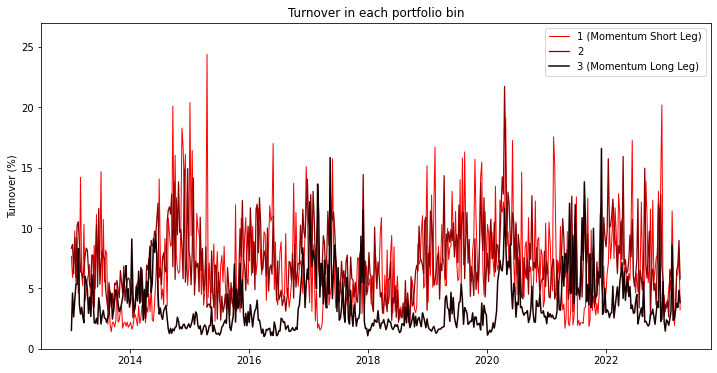

In [56]:
turnover = stocks5[['date','permno','ticker','ranksignal','vw_share','Lme','ret1w']]\
                .sort_values(by=['permno','date']).reset_index(drop=True)

# Computing lag portfolio weights and multiplying by market cap growth rate
#     Portfolio weights naturally grow ...
#            (i) at market cap growth rate (assuming dividends are not reinvested) or
#            (ii) at the security return (assuming dividends are reinvested)
#     We'll go with (ii) and assume dividends are reinvested in the same security:
turnover['lag_vw_share_end'] =  turnover[['permno','vw_share']].groupby('permno').shift(1)['vw_share'] * (1 + turnover['ret1w']) 

# Notice that 'lag_vw_share_end' no longer sum to one within each portfolio bin
#     Compute the sum of 'lag_vw_share_end' within each date  and portfolio bin
turnover = turnover.merge(turnover[['date','ranksignal','lag_vw_share_end']]\
                              .groupby(['date','ranksignal']).sum().reset_index().rename(columns={"lag_vw_share_end":"lag_vw_share_end_sum"}),\
                                     on=['date','ranksignal'],how='left')
turnover.loc[turnover['lag_vw_share_end_sum'] <= 0,'lag_vw_share_end_sum'] = np.nan
#     Devide 'lag_vw_share_end' by 'lag_vw_share_end_sum' and multiply by 100---these are the end-of-the-week weights
turnover['lag_vw_share_end'] = 1e2 * turnover['lag_vw_share_end'] / turnover['lag_vw_share_end_sum'] 

# Cumputing change in portfolio weights --- assuming long-only positions in each portfolio bin!
turnover['delta_share'] = 1e-2 * (turnover['vw_share'] - turnover['lag_vw_share_end'].fillna(0))
turnover['delta_share'] = turnover['delta_share'].abs()

turnover = turnover[turnover['date'].dt.year >= 2013]
turnover = turnover.sort_values(by=['ranksignal','date']).reset_index(drop=True)
turnover = turnover[['ranksignal','date','delta_share']]\
                  .groupby(['ranksignal','date']).sum().reset_index()\
                  .rename(columns={'delta_share':'turnover'})
turnover['turnover'] = turnover['turnover'] / 2
turnover = turnover.pivot(index = 'date',columns = 'ranksignal',values = 'turnover')

import matplotlib.pyplot as plt
import matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(0,K):
    l=str(i+1)
    if i == 0:   l = l + ' (Momentum Short Leg)'
    if i == K-1: l = l + ' (Momentum Long Leg)'
    ax.plot(100 * turnover.iloc[:,i],label=l,color=(0.1+0.9*(1-i/(K-1)), 0, 0),linewidth=1.5-0.5*(1-i/(K-1)))
ax.legend()
ax.set_ylabel('Turnover (%)')
ax.set_ylim(0,1.1 * 100*turnover.max().max() // 1 + 1)
ax.set_title('Turnover in each portfolio bin')

# In case you want to report y-axis in log scale (might be useful sometimes)
# ax.set_yscale('log')
# ax.set_ylabel('Turnover (%) --- log scale')
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# Checking largest positions (most recent week)

In [57]:
pd.set_option('display.expand_frame_repr', False)
print(' SHORT LEG OF THE TRADE (10 largest securities)')
print(stocks5.loc[(stocks5['ranksignal'] == 1) & 
                        (stocks5['date'] == stocks5['date'].max()),\
                  ['date','comnam','permno','ticker','ranksignal','Lme','vw_share']].tail(10))

 SHORT LEG OF THE TRADE (10 largest securities)
             date                      comnam  permno ticker  ranksignal      Lme  vw_share
928359 2023-03-31  ADVANCED MICRO DEVICES INC   61241    AMD           1   157.93      1.88
928360 2023-03-31  VERIZON COMMUNICATIONS INC   65875     VZ           1   158.17      1.88
928361 2023-03-31              DISNEY WALT CO   26403    DIS           1   171.56      2.04
928362 2023-03-31                   ADOBE INC   75510   ADBE           1   174.32      2.07
928363 2023-03-31          SALESFORCE COM INC   90215    CRM           1   190.06      2.26
928364 2023-03-31              SALESFORCE INC   90215    CRM           1   190.06      2.26
928365 2023-03-31                   TESLA INC   93436   TSLA           1   601.27      7.16
928366 2023-03-31                ALPHABET INC   90319  GOOGL           1   629.79      7.49
928367 2023-03-31                ALPHABET INC   14542   GOOG           1   645.48      7.68
928368 2023-03-31              A

In [58]:
print(' LONG LEG OF THE TRADE (10 largest securities)')
print(stocks5.loc[(stocks5['ranksignal'] == K) & 
                        (stocks5['date'] == stocks5['date'].max()),\
                  ['date','comnam','permno','ticker','ranksignal','Lme','vw_share']].tail(10))

 LONG LEG OF THE TRADE (10 largest securities)
              date               comnam  permno ticker  ranksignal    Lme  vw_share
2359323 2023-03-31          PEPSICO INC   13856    PEP           3 246.73      1.66
2359324 2023-03-31         COCA COLA CO   11308     KO           3 263.36      1.77
2359325 2023-03-31   MERCK & CO INC NEW   22752    MRK           3 265.71      1.78
2359326 2023-03-31           ABBVIE INC   13721   ABBV           3 279.46      1.88
2359327 2023-03-31       LILLY ELI & CO   50876    LLY           3 331.80      2.23
2359328 2023-03-31       MASTERCARD INC   91233     MA           3 335.39      2.25
2359329 2023-03-31             VISA INC   92611      V           3 359.89      2.42
2359330 2023-03-31  JPMORGAN CHASE & CO   47896    JPM           3 366.39      2.46
2359331 2023-03-31     EXXON MOBIL CORP   11850    XOM           3 426.37      2.86
2359332 2023-03-31          NVIDIA CORP   86580   NVDA           3 658.76      4.42


# Computing Value-weighted returns and merging with MTUM data

In [59]:
stocks6 = stocks5.copy()

# Value-weighted returns
stocks6['vwret1w'] = 1e-2 * stocks6['ret1w'] * stocks6['vw_share']
stocks6 = stocks6[['date','ranksignal','vwret1w']].groupby(['date','ranksignal'])['vwret1w']\
                .sum().reset_index().rename(columns={"vwret1w":"vwret"})
# Merging with equally-weighted returns
stocks6 = stocks6.merge(stocks5[['date','ranksignal','ret1w']]\
                        .groupby(['date','ranksignal'])['ret1w'].mean().reset_index()\
                        .rename(columns={"ret1w":"ewret"}),on=['date','ranksignal'],how='left')
stocks6

,date,ranksignal,vwret,ewret
0,2011-02-04,1,0.03,0.02
1,2011-02-04,2,0.03,0.03
2,2011-02-04,3,0.03,0.02
3,2011-07-29,1,-0.03,-0.04
4,2011-07-29,2,-0.05,-0.06
...,...,...,...,...
1828,2023-03-24,2,0.01,0.00
1829,2023-03-24,3,0.01,0.01
1830,2023-03-31,1,0.04,0.03
1831,2023-03-31,2,0.03,0.03


In [60]:
MTUM = pd.read_pickle(data_folder + 'MTUM_weekly.pkl')
MTUM['ranksignal'] = K+1
MTUM['ewret'] = MTUM['ret']
MTUM['vwret'] = MTUM['ret']
MTUM = MTUM[['date','ranksignal','ewret','vwret']].sort_values('date').reset_index(drop=True).copy()
MTUM

,date,ranksignal,ewret,vwret
0,2013-04-19,4,0.00,0.00
1,2013-04-26,4,0.02,0.02
2,2013-05-03,4,0.02,0.02
3,2013-05-10,4,0.01,0.01
4,2013-05-17,4,0.01,0.01
...,...,...,...,...
515,2023-03-03,4,0.01,0.01
516,2023-03-10,4,-0.04,-0.04
517,2023-03-17,4,-0.02,-0.02
518,2023-03-24,4,0.02,0.02


In [61]:
momentum = stocks6.append(MTUM)
momentum = momentum.sort_values(['date','ranksignal']).reset_index().drop(['index'], axis = 1)
momentum

/var/folders/dv/rl5slpl51q13m1rpvycdrgrc0000gn/T/ipykernel_11635/4083867401.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  momentum = stocks6.append(MTUM)


,date,ranksignal,vwret,ewret
0,2011-02-04,1,0.03,0.02
1,2011-02-04,2,0.03,0.03
2,2011-02-04,3,0.03,0.02
3,2011-07-29,1,-0.03,-0.04
4,2011-07-29,2,-0.05,-0.06
...,...,...,...,...
2348,2023-03-24,4,0.02,0.02
2349,2023-03-31,1,0.04,0.03
2350,2023-03-31,2,0.03,0.03
2351,2023-03-31,3,0.04,0.03


# Performance of each portoflio bins versus MTUM

<AxesSubplot:xlabel='date'>

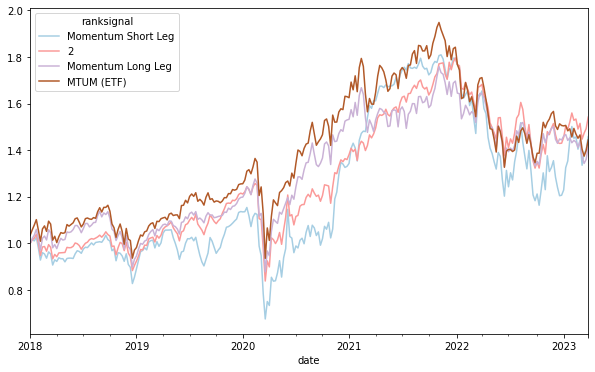

In [62]:
performance_plot = momentum[(momentum['date'].dt.year >= 2018)].copy()
performance_plot['ret1w_aux'] = performance_plot['vwret'] + 1
performance_plot['acc_ret'] = performance_plot.groupby(['ranksignal'])['ret1w_aux'].cumprod() 
performance_plot = performance_plot[['date','ranksignal','acc_ret']]\
                            .pivot(index = 'date',columns = 'ranksignal',values = 'acc_ret')
performance_plot.iloc[:,[0,1,2]] = performance_plot.iloc[:,[0,1,2]] / performance_plot.iloc[0,[0,1,2]]
performance_plot = performance_plot.rename(columns={1:"Momentum Short Leg",
                                                    K:"Momentum Long Leg",
                                                    K+1:"MTUM (ETF)"})
performance_plot.plot(colormap='Paired',figsize=(10,6))

<AxesSubplot:xlabel='date'>

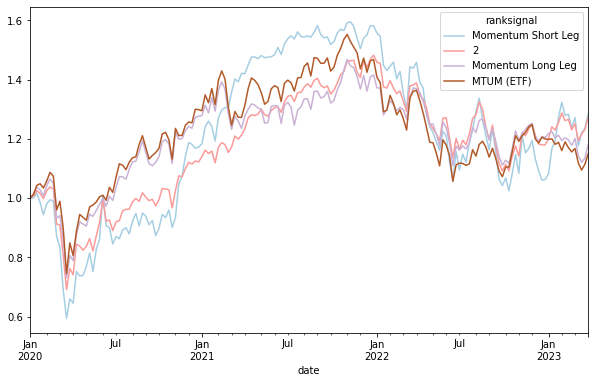

In [63]:
performance_plot = momentum[(momentum['date'].dt.year >= 2020)].copy()
performance_plot['ret1w_aux'] = performance_plot['vwret'] + 1
performance_plot['acc_ret'] = performance_plot.groupby(['ranksignal'])['ret1w_aux'].cumprod() 
performance_plot = performance_plot[['date','ranksignal','acc_ret']]\
                        .pivot(index = 'date',columns = 'ranksignal',values = 'acc_ret')
performance_plot.iloc[:,[0,1,2]] = performance_plot.iloc[:,[0,1,2]] / performance_plot.iloc[0,[0,1,2]]
performance_plot = performance_plot.rename(columns={1:"Momentum Short Leg",
                                                    K:"Momentum Long Leg",
                                                    K+1:"MTUM (ETF)"})
performance_plot.plot(colormap='Paired',figsize=(10,6))

In [64]:
recent_performance = momentum[['date','ranksignal','vwret']]\
                            .pivot(index = 'date',columns = 'ranksignal',values = 'vwret')\
                            .reset_index().sort_values('date')
recent_performance.iloc[:,1:] = recent_performance.iloc[:,1:] * 100
recent_performance = recent_performance.rename(columns={1:"Short Leg",K:"Long Leg",K+1:"MTUM"})
recent_performance
pd.set_option('display.expand_frame_repr', False,'display.float_format','{:,.2f}'.format)
print(' ')
print('RECENT PERFORMANCE (last 12 weeks)')
print(recent_performance.tail(12))

 
RECENT PERFORMANCE (last 12 weeks)
ranksignal       date  Short Leg     2  Long Leg  MTUM
599        2023-01-13       7.83  3.31      0.51  0.14
600        2023-01-20       2.13 -0.86     -1.75 -1.55
601        2023-01-27       6.67  2.06      0.78  0.58
602        2023-02-03       4.01  2.57     -1.47 -2.37
603        2023-02-10      -3.35 -2.02      0.73  2.54
604        2023-02-17       0.37  0.36     -0.52 -1.61
605        2023-02-24      -3.60 -2.80     -1.59 -1.24
606        2023-03-03       2.77  1.64      1.97  0.99
607        2023-03-10      -7.48 -4.47     -4.82 -4.17
608        2023-03-17       3.72  1.78     -1.99 -2.15
609        2023-03-24       1.18  1.31      1.30  1.79
610        2023-03-31       4.08  3.32      4.02  3.18
